In [3]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

total_events           int64
total_views          float64
total_purchases      float64
unique_categories      int64
last_event_time       object
conversion_rate      float64
user_id                int32
dtype: object
⚠️ Des NaN détectés, ils vont être remplacés par la médiane.
✅ Vérification terminée. Pas de valeurs infinies ou extrêmes restantes.


c:\Users\Pierre\Desktop\Evaluation école\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


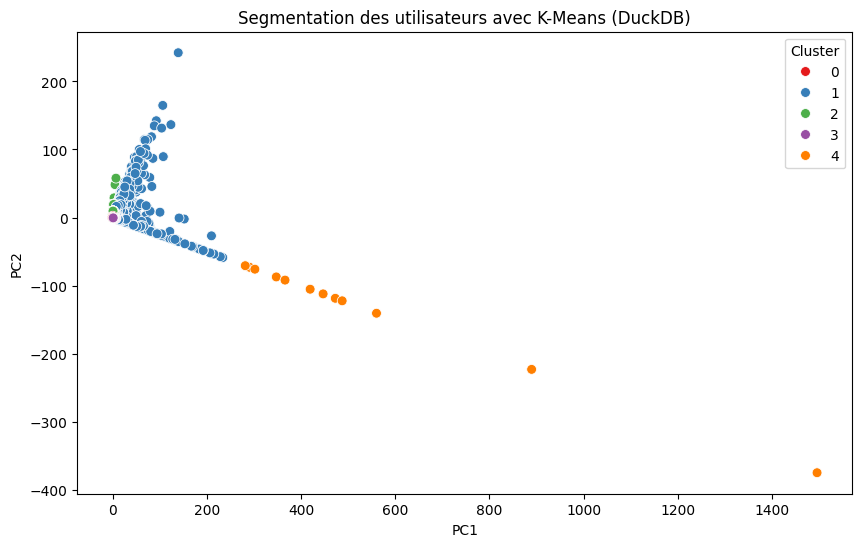


🔍 Analyse des comportements par cluster :

   cluster  total_events   total_views  total_purchases  unique_categories  \
0        0      6.464527      6.407052         0.057474           1.205105   
1        1    369.216636    359.090021        10.126615           3.254543   
2        2     11.010312      8.407901         2.602412           1.275596   
3        3     48.669194     48.121955         0.547239           3.131909   
4        4  22401.916667  22401.916667         0.000000           3.500000   

   conversion_rate  
0         0.004019  
1         0.066522  
2         0.432804  
3         0.012519  
4         0.000000  


C:\Users\Pierre\AppData\Local\Temp\ipykernel_22888\921434431.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_users, x="cluster", y="conversion_rate", palette='Set1')


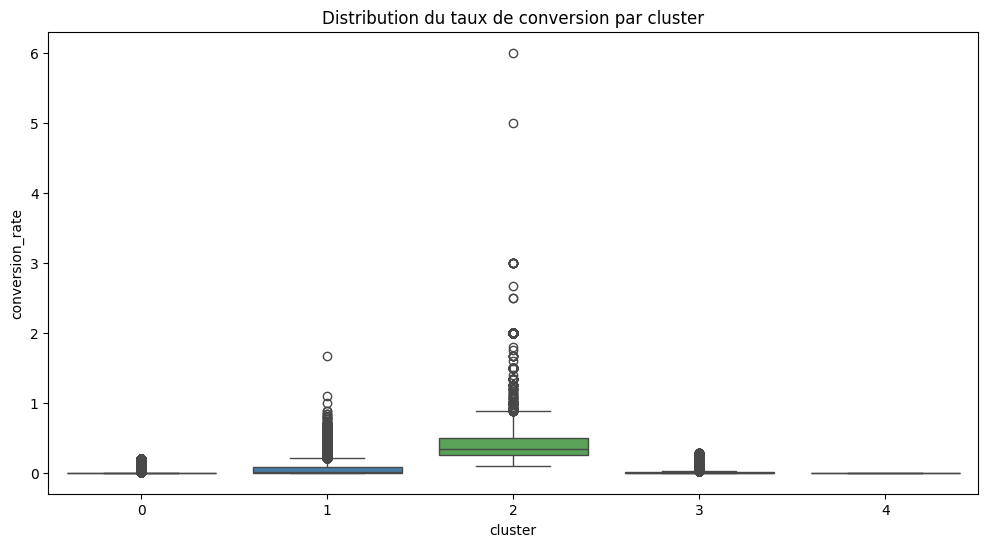

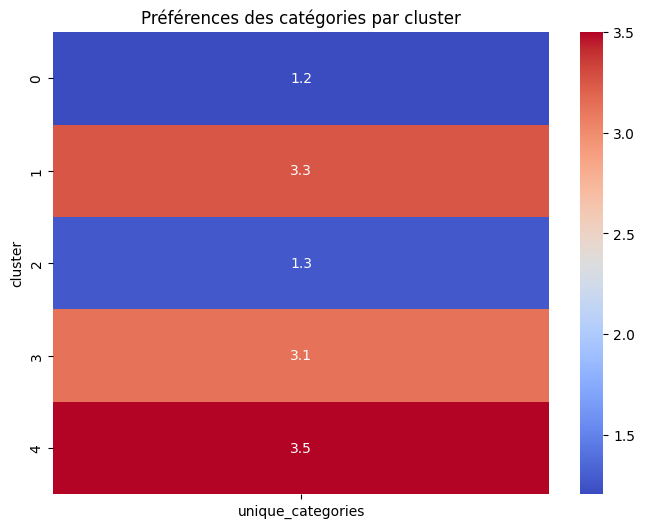

✅ Clustering et analyse terminés !


In [7]:
# 📂 Chargement des données depuis DuckDB
con = duckdb.connect(database=':memory:')
file_path = '../data/output/user_features.parquet'
df_users = conn.execute("SELECT * FROM '../data/output/user_features.parquet'").fetchdf()  # Convertit directement en DataFrame

# Vérifier la structure des données
print(df_users.dtypes)

# Remplacer les valeurs infinies par NaN
df_users.replace([np.inf, -np.inf], np.nan, inplace=True)
if df_users.isna().sum().sum() > 0:
    print("⚠️ Des NaN détectés, ils vont être remplacés par la médiane.")
    df_users.fillna(df_users.median(numeric_only=True), inplace=True)
print("✅ Vérification terminée. Pas de valeurs infinies ou extrêmes restantes.")

# 📊 Sélection des variables pertinentes pour le clustering
features = ['total_events', 'total_views', 'total_purchases', 'unique_categories', 'conversion_rate']
X = df_users[features]

# ⚖️ Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🎯 Réduction de dimension avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 🚀 Application du K-Means avec 5 clusters (modifiable selon les besoins)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_users['cluster'] = kmeans.fit_predict(X_scaled)

# 🔍 Visualisation des clusters après PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_users['cluster'], palette='Set1', s=50)
plt.title("Segmentation des utilisateurs avec K-Means (DuckDB)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()

# 📊 Analyse des comportements par cluster
df_analysis = df_users.groupby("cluster").agg({
    "total_events": "mean",
    "total_views": "mean",
    "total_purchases": "mean",
    "unique_categories": "mean",
    "conversion_rate": "mean"
}).reset_index()

print("\n🔍 Analyse des comportements par cluster :\n")
print(df_analysis)

# 📈 Distribution du taux de conversion par cluster
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_users, x="cluster", y="conversion_rate", palette='Set1')
plt.title("Distribution du taux de conversion par cluster")
plt.show()

# 🔥 Heatmap des catégories uniques consultées par cluster
pivot_table = df_users.pivot_table(index="cluster", values="unique_categories", aggfunc="mean")
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, cmap="coolwarm", annot=True)
plt.title("Préférences des catégories par cluster")
plt.show()

print("✅ Clustering et analyse terminés !")